# Full Boss NUM density

In [43]:
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
import esutil
import numpy as np

path = '/n/des/lee.5922/data/cmass_cat/'

cmass_full = esutil.io.read(path+'galaxy_DR12v5_CMASS_North.fits.gz')
cmass_sgc = esutil.io.read(path+'galaxy_DR12v5_CMASS_South.fits.gz')
cmass_full = cmass_full[(cmass_full['Z'] > 0.43) & (cmass_full['Z'] < 0.7)]
cmass_sgc = cmass_sgc[(cmass_sgc['Z'] > 0.43) & (cmass_sgc['Z'] < 0.7)]
cmass_train = Cuts.SpatialCuts(cmass_sgc, ra=310, ra2=360, dec=-2, dec2=2)

Spatial Cut  14165


In [3]:
cmass_mock_file = np.loadtxt(path+'Patchy-Mocks-DR12CMASS-N-V6C-Portsmouth-mass_0987.dat')
cmass_mock = np.zeros( (cmass_mock_file.shape[0],), dtype = [('RA', 'float'), ('DEC', 'float'), ('Z', 'float')])
cmass_mock['RA'] = cmass_mock_file[:,0]
cmass_mock['DEC'] = cmass_mock_file[:,1]
cmass_mock['Z'] = cmass_mock_file[:,2]
cmass_mock = cmass_mock[(cmass_mock['Z'] > 0.43) & (cmass_mock['Z'] < 0.7)]

cmass_mock_rand_file = np.loadtxt(path+'Random-DR12CMASS-N-V6C-x10.dat')
random_mock = np.zeros( (cmass_mock_rand_file.shape[0],), dtype = [('RA', 'float'), ('DEC', 'float'), ('Z', 'float')])
random_mock['RA'] = cmass_mock_rand_file[:,0]
random_mock['DEC'] = cmass_mock_rand_file[:,1]
random_mock['Z'] = cmass_mock_rand_file[:,2]

figsave : figure/spatialtest_.png


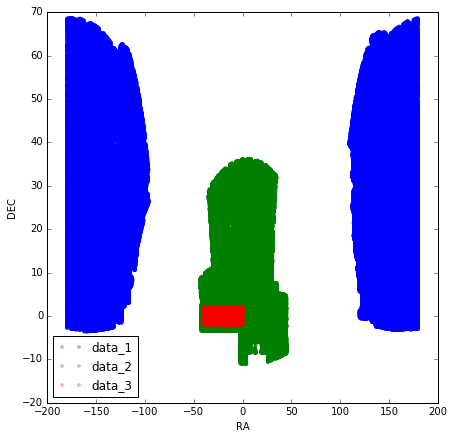

In [71]:
spatialcheck([cmass_full, cmass_sgc, cmass_train])

In [25]:
# random catalogues

random_full = esutil.io.read(path+'random0_DR12v5_CMASS_North.fits.gz')
random_sgc = esutil.io.read(path+'random0_DR12v5_CMASS_South.fits.gz')

random_full = random_full[(random_full['Z'] > 0.43) & (random_full['Z'] < 0.7)]
random_sgc = random_sgc[(random_sgc['Z'] > 0.43) & (random_sgc['Z'] < 0.7)]

random_train = Cuts.SpatialCuts(random_sgc, ra=320, ra2=360, dec=-2, dec2=2)

Spatial Cut  623265


In [26]:
def CalculateNumDensity(cat, random, weight = True):
    
    if weight is False :
        try:
            num_density = cat.size * 1./random.size 
        except ZeroDivisionError: num_density = 0.0
        
    if weight is True :
        try : num_density = np.sum( cat['WEIGHT_SYSTOT']*( cat['WEIGHT_CP'] +cat['WEIGHT_NOZ'] - 1 )) * 1./random.size 
        except ZeroDivisionError: num_density = 0.0
        
    return num_density

In [27]:
# add jack knife error
def jkerror( catalog, random, njack = 3 ):
    import os
    #from suchyta_utils import _jkfunctions as _jk

    # jk error
    jkfile = './jkregion.txt'
    jk.GenerateJKRegions( catalog['RA'], catalog['DEC'], njack, jkfile)
    jktest = jk.SphericalJK( target = CalculateNumDensity, jkargs=[catalog, random], jkargsby=[['RA', 'DEC'],['RA', 'DEC']], \
                            nojkargs=[], regions = jkfile)
    jktest.DoJK( regions = jkfile )
    jkresults = jktest.GetResults(jk=True, full = True)

    
    full_j = jkresults['full']   
    it = jkresults['it']
    it_j = jkresults['jk']

    norm = (njack-1)*1./njack
    #cov = np.std(it_j)**2 * norm
    cov = np.sum((it_j - it_j.mean())**2) * norm
    
    
    os.remove(jkfile)
    return it_j.mean(), it_j, np.sqrt(cov)

0 1
2 3
4 5
6 7
8 9
10 11
12 13
14 15
16 17
18 19
20 21
22 23
24 25
26 27
28 29
30 31
32 33
34 35
36 37
38 39
40 41
42 43
44 45
46 47
48 49
50 51
52 53
54 55
56 57
58 59
60 61
62 63
64 65
66 67
68 69
70 71
72 73
74 75
76 77
78 79
80 81
82 83
84 85
86 87
88 89
90 91
92 93
94 95
96 97
98 99
100 101
102 103
104 105
106 107
108 109
110 111
112 113
114 115
116 117
118 119
120 121
122 123
124 125
126 127
128 129
130 131
132 133
134 135
136 137
138 139
140 141
142 143
144 145
146 147
148 149
150 151
152 153
154 155
156 157
158 159
160 161
162 163
164 165
166 167


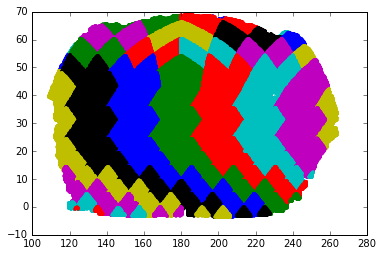

In [27]:
# stat error

nside = 8
hpix8 = hpRaDecToHEALPixel(cmass_full['RA'], cmass_full['DEC'], nside= nside )
hpix8rand = hpRaDecToHEALPixel(random_full['RA'], random_full['DEC'], nside= nside )
apix8 = hp.nside2pixarea(nside, degrees=True)

hpix8list = list(set(hpix8))
n_density = np.zeros(len(hpix8list)-1)
N = np.zeros(len(hpix8list)-1)
N_rand = np.zeros(len(hpix8list)-1)

fig, ax = plt.subplots()
for j in np.arange(0, len(hpix8list)-1, 2):
    print j, j+1
    ma = hpix8 == hpix8list[j]
    ma2 = hpix8 == hpix8list[j+1]
    ma3 = hpix8rand == hpix8list[j]
    ma4 = hpix8rand == hpix8list[j+1]
    n_density[j] = CalculateNumDensity(np.hstack([cmass_full[ma], cmass_full[ma2]]),\
                                           np.hstack([random_full[ma3], random_full[ma4]]), weight = True)
    N[j] = np.sum(ma) + np.sum(ma2)
    N_rand[j] = np.sum(ma3)+np.sum(ma4)
    ax.plot(cmass_full[ma]['RA'], cmass_full[ma]['DEC'], '.')  
    ax.plot(cmass_full[ma2]['RA'], cmass_full[ma2]['DEC'], color = ax.lines[-1].get_color(), marker='.')  

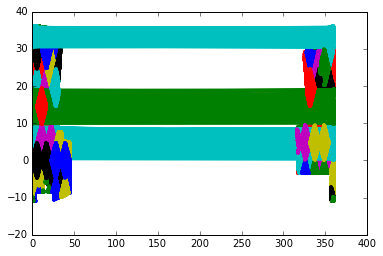

In [28]:
nside = 8
hpix8 = hpRaDecToHEALPixel(cmass_sgc['RA'], cmass_sgc['DEC'], nside= nside )
hpix8rand = hpRaDecToHEALPixel(random_sgc['RA'], random_sgc['DEC'], nside= nside )
apix8 = hp.nside2pixarea(nside, degrees=True)

hpix8list = list(set(hpix8))
n_density_sgc = np.zeros(len(hpix8list)-1)
N_sgc = np.zeros(len(hpix8list)-1)
N_rand_sgc = np.zeros(len(hpix8list)-1)

fig, ax = plt.subplots()
for j in np.arange(0, len(hpix8list)-1, 2):
    ma = hpix8 == hpix8list[j]
    ma2 = hpix8 == hpix8list[j+1]
    ma3 = hpix8rand == hpix8list[j]
    ma4 = hpix8rand == hpix8list[j+1]
    n_density_sgc[j] = CalculateNumDensity(np.hstack([cmass_sgc[ma], cmass_sgc[ma2]]),\
                                           np.hstack([random_sgc[ma3], random_sgc[ma4]]), weight = True)
    #(np.sum(ma)+np.sum(ma2)) * 1./(np.sum(ma3) + np.sum(ma4))
    N_sgc[j] = np.sum(ma) + np.sum(ma2)
    N_rand_sgc[j] = np.sum(ma3)+np.sum(ma4)
    ax.plot(cmass_sgc[ma]['RA'], cmass_sgc[ma]['DEC'], '.')  
    ax.plot(cmass_sgc[ma2]['RA'], cmass_sgc[ma2]['DEC'], color = ax.lines[-1].get_color(), marker='.')   

In [18]:
print n_density[~np.ma.masked_invalid(n_density).mask].mean()
print n_density_sgc[~np.ma.masked_invalid(n_density_sgc).mask].mean()
print n_density[~np.ma.masked_invalid(n_density).mask].mean() / n_density_sgc[~np.ma.masked_invalid(n_density_sgc).mask].mean()

0.0204591106548
0.0213670103403
0.957509278508


In [13]:
n_density_st = CalculateNumDensity(cmass_train, random_train, weight = True)
print n_density_st

0.0223267948074


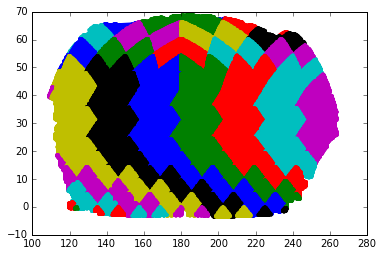

In [31]:
# stat error

nside = 8
hpix8 = hpRaDecToHEALPixel(cmass_mock['RA'], cmass_mock['DEC'], nside= nside )
hpix8rand = hpRaDecToHEALPixel(random_mock['RA'], random_mock['DEC'], nside= nside )
apix8 = hp.nside2pixarea(nside, degrees=True)

hpix8list = list(set(hpix8))
n_density_mock = np.zeros(len(hpix8list)-1)
N_mock = np.zeros(len(hpix8list)-1)
N_rand_mock = np.zeros(len(hpix8list)-1)

fig, ax = plt.subplots()
for j in np.arange(0, len(hpix8list)-1, 2):
    ma = hpix8 == hpix8list[j]
    ma2 = hpix8 == hpix8list[j+1]
    ma3 = hpix8rand == hpix8list[j]
    ma4 = hpix8rand == hpix8list[j+1]
    N_mock[j] = np.sum(ma) + np.sum(ma2)
    N_rand_mock[j] = np.sum(ma3)+np.sum(ma4)
    n_density_mock[j] = N_mock[j] * 1./N_rand_mock[j]
    ax.plot(cmass_mock[ma]['RA'], cmass_mock[ma]['DEC'], '.')  
    ax.plot(cmass_mock[ma2]['RA'], cmass_mock[ma2]['DEC'], color = ax.lines[-1].get_color(), marker='.')  

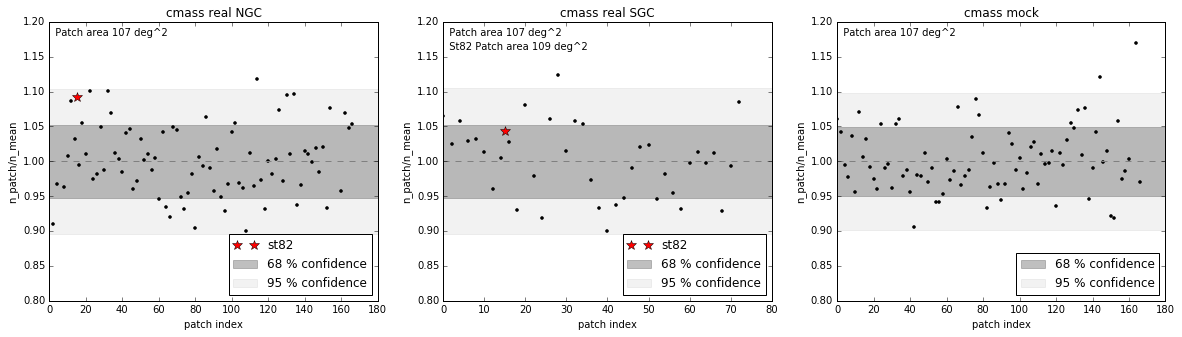

In [32]:
# NGC --------------------------------------
mask = N_rand > N_rand.mean() * 0.1
mean = n_density[mask].mean()

# SGC --------------------------------------
sgc_mask = (N_rand_sgc > N_rand_sgc.mean() * 0.1)# & (n_density_sgc != 0)
mean_sgc = n_density_sgc[sgc_mask].mean()

# MOCK --------------------------------------
mock_mask = N_rand_mock > N_rand_mock.mean() * 0.1
mean_mock = n_density_mock[mock_mask].mean()


# plot------------------
fig,(ax, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 5))

# Define st82 number density uncertainty ----
defined_sigma_st82 = np.std(n_density[mask])

ax.axhspan( 1. - defined_sigma_st82/mean, 1 + defined_sigma_st82/mean, alpha=0.5, color='grey', label = '68 % confidence')
ax.axhspan( 1. - 2*defined_sigma_st82/mean, 1 + 2*defined_sigma_st82/mean, alpha=0.1, color='grey', linestyle = None, label = '95 % confidence')
#ax.errorbar( np.arange(n_density.size)[mask], n_density[mask]/mean, yerr = sigma_f[mask], fmt='none' )
ax.plot( np.arange(n_density.size)[mask], n_density[mask]/mean, marker = '.' , linestyle = 'none', color = 'black' )
ax.plot( 15, n_density_st/mean, marker = '*', color = 'red',  markersize = 10, linestyle = 'none', label = 'st82')
ax.axhline(y = 1, linestyle='--', color = 'grey')
ax.set_title('cmass real NGC')
ax.set_ylim(0.8, 1.2)
ax.legend(loc=4)
ax.set_ylabel('n_patch/n_mean')
ax.set_xlabel('patch index')
ax.text(0, 1.18, '  Patch area {:0.0f} deg^2'.format(apix8 * 2))


# Define st82 number density uncertainty ----
defined_sigma_st82 = np.std(n_density_sgc[sgc_mask])

ax2.axhspan( 1. - defined_sigma_st82/mean_sgc, 1 + defined_sigma_st82/mean_sgc, alpha=0.5, color='grey', label = '68 % confidence')
ax2.axhspan( 1. - 2*defined_sigma_st82/mean_sgc, 1 + 2*defined_sigma_st82/mean_sgc, alpha=0.1, color='grey', label = '95 % confidence')
ax2.plot( np.arange(n_density_sgc.size)[sgc_mask], n_density_sgc[sgc_mask]/mean_sgc, marker = '.', linestyle = 'none', color = 'black')
ax2.plot( 15, n_density_st/mean_sgc, marker = '*', markersize = 10, linestyle='none' , color = 'red', label = 'st82')
ax2.axhline(y = 1, linestyle='--', color = 'grey')
ax2.set_title('cmass real SGC')
ax2.set_ylim(0.8, 1.2)
ax2.legend(loc=4)
ax2.set_ylabel('n_patch/n_mean')
ax2.set_xlabel('patch index')
ax2.text(0, 1.18, '  Patch area {:0.0f} deg^2'.format(apix8 * 2))
ax2.text(0, 1.16, '  St82 Patch area {:0.0f} deg^2'.format(109))


# Define st82 number density uncertainty ----

# Define st82 number density uncertainty ----
defined_sigma_st82 = np.std(n_density_mock[mock_mask])

ax3.axhspan( 1. - defined_sigma_st82/mean_mock, 1 + defined_sigma_st82/mean_mock, alpha=0.5, color='grey', label = '68 % confidence')
ax3.axhspan( 1. - 2*defined_sigma_st82/mean_mock, 1 + 2*defined_sigma_st82/mean_mock, alpha=0.1, color='grey', label = '95 % confidence')
ax3.plot( np.arange(n_density_mock.size)[mock_mask], n_density_mock[mock_mask]/mean_mock, \
            linestyle='none', marker ='.', color='black')
ax3.axhline(y = 1, linestyle='--', color = 'grey')
ax3.set_title('cmass mock')
ax3.set_ylim(0.8, 1.2)
ax3.set_ylabel('n_patch/n_mean')
ax3.set_xlabel('patch index')
ax3.legend(loc = 4)
ax3.text(0, 1.18, '  Patch area {:0.0f} deg^2'.format(apix8 * 2))

## Calling dmass sample and create randoms

In [7]:
# calling dmass sample
#merged_des_patch_s = esutil.io.read('result_cat/gold_24_cut21_merged_des_patch_s.fits')

dmass_st82 = esutil.io.read('result_cat/gold_st82_30_cut21_dmass_st82.fits')
dmass_spt = esutil.io.read('result_cat/dmass_spt_30.fits')
#ra = dmass_spt['RA'][dmass_spt['RA'] < 0] + 360
#dmass_spt['RA'][dmass_spt['RA'] < 0] = ra
#dmass_spt, _ = resampleWithPth( merged_des_patch_s, pstart = 0, pmax = 1.0 )
dmass = np.hstack([dmass_spt, dmass_st82])

clean_cmass_data_des = fitsio.read('result_cat/clean_cmass_data_des.fits')
random = uniform_random_on_sphere(dmass, size = int(dmass.size * clean_cmass_data_des.size *1./dmass_st82.size * 50) )
random = Cuts.keepGoodRegion(random)
random_spt = random[random['DEC'] < -3]
#random_st82 = Cuts.SpatialCuts(random, ra = -40, ra2 = 0, dec = -2, dec2 = 2)
random_s82 = random[random['DEC'] > -3]

In [50]:
# 
# SGC --------------------------------------
bins, step = np.linspace ( 0.8, 1.2, 12, retstep = True )
#N_ngc, _ = np.histogram( n_density[mask]/n_density[mask].mean(), bins = bins  )
#N_mock, _ = np.histogram( n_density_mock[mock_mask]/n_density_mock[mock_mask].mean(), bins = bins  )
N_sgc, _ = np.histogram( n_density_sgc[sgc_mask]/n_density_sgc[sgc_mask].mean(), bins = bins , normed=True )
N_spt, _ = np.histogram( n_density_spt[spt_mask]/n_density_spt[spt_mask].mean(), bins = bins , normed = True )

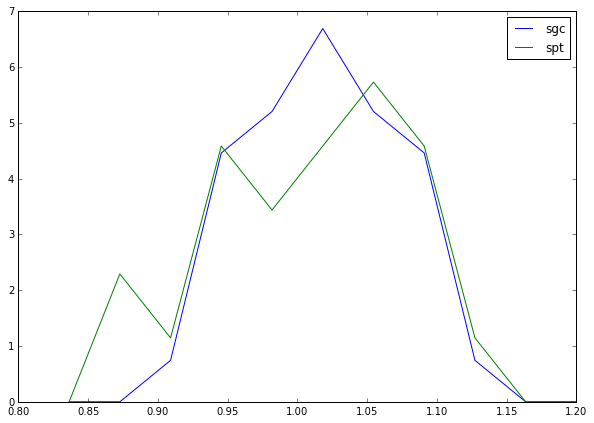

In [51]:
fig, ax = plt.subplots(figsize = (10, 7))
#ax.plot( bins[:-1] + step, N_ngc, '-', label='ngc')
ax.plot( bins[:-1] + step, N_sgc, '-',  label='sgc')
#ax.plot( bins[:-1] + step, N_mock, '-',  label='mock')
ax.plot( bins[:-1] + step, N_spt, '-',  label='spt')
ax.legend(loc = 'best')

avg bias= 1.16067265975  sample size= 68
avg bias= 1.1632779075  sample size= 1825
avg bias= 1.17236037747  sample size= 2551
avg bias= 1.15053425283  sample size= 4463
avg bias= 1.13702894287  sample size= 3991
avg bias= 1.16025499579  sample size= 4149
avg bias= 1.20576798817  sample size= 602
avg bias= 1.13776783441  sample size= 840
avg bias= 1.16321090388  sample size= 2007
avg bias= 1.15818394672  sample size= 3766
avg bias= 1.16298801878  sample size= 4200
avg bias= 1.14951738725  sample size= 4326
avg bias= 1.16339645021  sample size= 3817
avg bias= 1.1489894588  sample size= 3535
avg bias= 1.19764197799  sample size= 863
avg bias= 1.12608747887  sample size= 1848
avg bias= 1.13543134322  sample size= 640
avg bias= 1.20099191182  sample size= 3
avg bias= 1.13175891058  sample size= 126
avg bias= 1.24887717026  sample size= 592
avg bias= 1.15851151873  sample size= 1418
avg bias= 1.17949782505  sample size= 229
avg bias= 1.16140385333  sample size= 1271
avg bias= 1.14682472845  

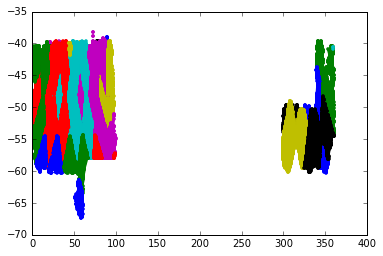

In [17]:
n_density_st82 = clean_cmass_data_des.size * 1./random_s82.size

nside = 8
hpix8 = hpRaDecToHEALPixel(dmass_spt['RA'], dmass_spt['DEC'], nside= nside )
hpix8rand = hpRaDecToHEALPixel(random['RA'], random['DEC'], nside= nside )
apix8 = hp.nside2pixarea(nside, degrees=True)


hpix8list = list(set(hpix8))
n_density_spt = np.zeros(len(hpix8list)-1)
N_spt = np.zeros(len(hpix8list)-1)
N_rand = np.zeros(len(hpix8list)-1)
avg_b_dmass_spt = np.zeros(len(hpix8list)-1)

fig, ax = plt.subplots()
for j in np.arange(0, len(hpix8list)-1, 2):
    ma = hpix8 == hpix8list[j]
    ma2 = hpix8 == hpix8list[j+1]
    ma3 = hpix8rand == hpix8list[j]
    ma4 = hpix8rand == hpix8list[j+1]
    n_density_spt[j] = (np.sum(ma)+np.sum(ma2)) * 1./(np.sum(ma3) + np.sum(ma4))
    N_spt[j] = np.sum(ma) + np.sum(ma2)
    N_rand[j] = np.sum(ma3)+np.sum(ma4)
    avg_b_dmass_spt[j] = getavgbias( dmass_spt[ma] )
    ax.plot(dmass_spt[ma]['RA'], dmass_spt[ma]['DEC'], '.')  
    ax.plot(dmass_spt[ma2]['RA'], dmass_spt[ma2]['DEC'], color = ax.lines[-1].get_color(), marker='.')  

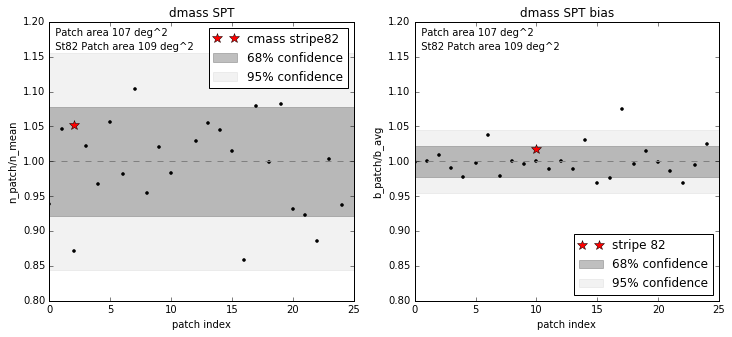

In [21]:
# MOCK --------------------------------------

spt_mask = (N_rand > N_rand.mean() * 0.2 )  & (n_density_spt > 0)
mean_spt = n_density_spt[spt_mask].mean() 
defined_sigma_st82 = np.std(n_density_spt[spt_mask])
spt_maskb = (N_rand > N_rand.mean() * 0.2 ) & (avg_b_dmass_spt < 100.0)
mean_b = avg_b_dmass_spt[spt_maskb].mean()
defined_sigma_st82_b = np.std(avg_b_dmass_spt[spt_maskb])

# plot------------------
fig, (ax, ax2) = plt.subplots(1, 2, figsize = (20/3 * 2., 5))
ax.axhspan( 1. - defined_sigma_st82/mean_spt, 1 + defined_sigma_st82/mean_spt, alpha=0.5, color='grey', label = '68% confidence')
ax.axhspan( 1. - 2*defined_sigma_st82/mean_spt, 1 + 2*defined_sigma_st82/mean_spt, alpha=0.1, color='grey',label = '95% confidence')
ax.plot( np.arange(np.sum(spt_mask)), n_density_spt[spt_mask]/mean_spt, 'k.' )
ax.plot( 2, n_density_st82/mean_spt, 'r*', markersize = 10, label = 'cmass stripe82' )
ax.axhline(y = 1, linestyle='--', color = 'grey')
ax.set_title('dmass SPT')
ax.set_ylim(0.8, 1.2)
ax.set_ylabel('n_patch/n_mean')
ax.set_xlabel('patch index')
ax.text(0, 1.18, '  Patch area {:0.0f} deg^2'.format(apix8 * 2))
ax.text(0, 1.16, '  St82 Patch area {:0.0f} deg^2'.format(109))
ax.legend(loc = 1)


ax2.axhspan( 1. - defined_sigma_st82_b/mean_b, 1 + defined_sigma_st82_b/mean_b, alpha=0.5, color='grey', label = '68% confidence')
ax2.axhspan( 1. - 2*defined_sigma_st82_b/mean_b, 1 + 2*defined_sigma_st82_b/mean_b, alpha=0.1, color='grey',label = '95% confidence')

ax2.plot( np.arange(np.sum(spt_maskb)), avg_b_dmass_spt[spt_maskb]/mean_b, 'k.')
ax2.plot( 10, avg_b_cmass/mean_b, 'r*', markersize = 10, label = 'stripe 82')
#ax.errorbar( 1, n_density_st82/mean_spt, yerr = sigma_f_st82, fmt='none', ecolor = 'red', label = 'stripe82' )
ax2.axhline(y = 1, linestyle='--', color = 'grey')
ax2.set_title('dmass SPT bias')
ax2.set_ylim(0.8, 1.2)
ax2.set_ylabel('b_patch/b_avg')
ax2.set_xlabel('patch index')
ax2.text(0, 1.18, '  Patch area {:0.0f} deg^2'.format(apix8*2))
ax2.text(0, 1.16, '  St82 Patch area {:0.0f} deg^2'.format(109))
ax2.legend(loc = 4)

In [19]:
def getavgbias( cat, pstart=0.0 ):
    from systematics_module.contCorrection import logL_from_mag,logL_to_galaxyBias
    mag = cat['MAG_MODEL_I']
    z = cat['DESDM_ZP']
    logL = logL_from_mag( mag = mag, z = z )
    avg_b = logL_to_galaxyBias(logL = logL)
    print 'avg bias=',avg_b, ' sample size=', mag.size
    return avg_b

In [20]:
avg_b_cmass = getavgbias( clean_cmass_data_des )
avg_b_dmass1 = getavgbias( dmass_spt )
avg_b_dmass2 = getavgbias( dmass_st82 )

print 'bias ratio b_dmass/b_cmass, spt', avg_b_dmass1 * 100/ avg_b_cmass, '%'
print 'bias ratio b_dmass/b_cmass, st82', avg_b_dmass2 * 100/ avg_b_cmass, '%'

avg bias= 1.18257475506  sample size= 11568
avg bias= 1.15720246626  sample size= 110270
avg bias= 1.19071755457  sample size= 11496
bias ratio b_dmass/b_cmass, spt 97.8544875328 %
bias ratio b_dmass/b_cmass, st82 100.688565308 %


In [48]:
def plot_z_distribution( cats = None, name = None, ztag = 'Z', area = None, labels = None, suffix = 'test' ):
    
    import matplotlib.pyplot as plt
    z_bin, s = np.linspace(0.1, 1.0, 200, retstep=True)
    z_center = z_bin[:-1]+s/2.
    
    
    fig, axes = plt.subplots( 1, 1, figsize = (9,6))
    
    color = ['blue', 'red', 'yellow']
    
    if len(cats) > 1:
        for i in range(len(cats)):
            N, _= np.histogram(cats[i][ztag], bins = z_bin, normed = True)  
            n = N*1./area[i]
            axes.bar(z_center, n, s, alpha = 0.5, color = color[i], label=name[i] )
    
    else : 
        N, _= np.histogram(cats[ztag], bins = z_bin, normed = True) 
        axes.bar(z_center, N*1./area, s, label = name)
        
    axes.set_xlabel(r'$DESDM$_$ZP$', size=20)
    axes.set_ylabel(r'$n(z)$', size=20)
    #ax.set_yscale('log')
    axes.legend(loc='best', fontsize=20)

    axes.tick_params(labelsize=20)
    #axes.set_title('\nredshift histogram')
    figname ='figure/hist_z_'+suffix+'.png'
    fig.savefig(figname)
    print 'saving fig to ',figname
    
    DAT = np.column_stack((z_center, N))
    filename = 'data_txt/z_distribution_'+suffix+'.txt'
    np.savetxt(filename, DAT, header = 'z, n(z)')
    print 'saving data to ',filename

Spatial Cut  15498
Spatial Cut  667883
saving fig to  figure/hist_z_cmass.png
saving data to  data_txt/z_distribution_cmass.txt


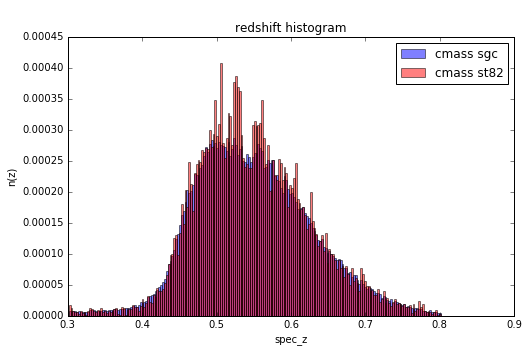

In [75]:
cmass_sgc = esutil.io.read(path+'galaxy_DR12v5_CMASS_South.fits.gz')
cmass_train = Cuts.SpatialCuts(cmass_sgc, ra=310, ra2=360, dec=-2, dec2=2)
random_train = Cuts.SpatialCuts(random_sgc, ra=310, ra2=360, dec=-2, dec2=2)
plot_z_distribution( cats = [cmass_sgc,cmass_train], name = ['cmass sgc', 'cmass st82'], \
                    area = [random_sgc.size, random_train.size], labels = 'cmass', suffix = 'cmass' )

In [8]:
# calling map 
from utils import *
from systematics import *

GoldMask = callingEliGoldMask()
GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

Spatial Cut  529721


saving fig to  figure/hist_z_cmass_dmass.png
saving data to  data_txt/z_distribution_cmass_dmass.txt


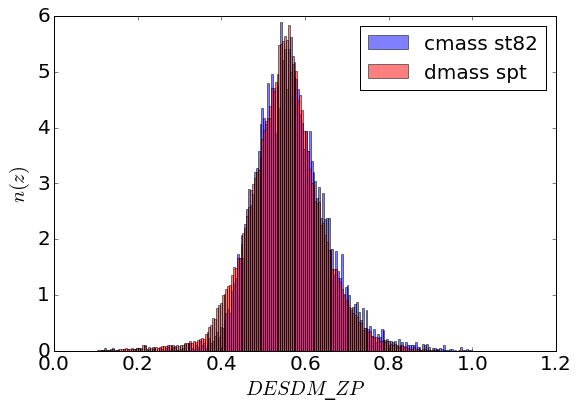

In [49]:
plot_z_distribution( cats = [clean_cmass_data_des, dmass_spt], name = ['cmass st82','dmass spt'], \
                    area = [1, 1], ztag = 'DESDM_ZP', labels = '', suffix = 'cmass_dmass' )

In [50]:
dmass_spt.size

110270